# * Kurapati Venkatesh

# * 09012021

# * Topic: Naive Bayes ✨

# ---------------------------------------------------------------------------

## Problem Statement:

## In this case study you have been given with tweeter data collected from an anonymous twitter handle, with the help of Naïve Bayes algorithm predict a given tweet is Fake or Real about real disaster occurring. 

## -----------------------------------------------------------------------------------

### Problem Objective:

##### To prepare a classification model using Naive Bayes and To predict the a given tweet is Fake or Real about real disaster occuring.

### Dataset info:

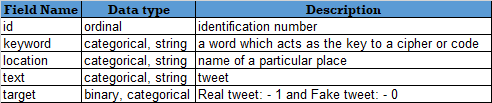

## Import libraries:

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # for data visualization purposes
import seaborn as sns # for statistical data visualization
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.metrics import make_scorer, roc_auc_score
np.random.seed(500)

In [3]:
import warnings

warnings.filterwarnings('ignore')

## Import dataset:

In [4]:
disaster_original = pd.read_csv(r"G:\360digit\assignments meterial\Naivebayes\Disaster_tweets_NB.csv")
disaster_original.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
disaster_original['target'].unique()

array([1, 0], dtype=int64)

In [6]:
disaster_original.shape

(7613, 5)

#### Drop Columns:

The id, keyword and location columns are all entirley null, and intuitively shouldn't add any value to the model's ability to classify the body of the tweet as disaster 1 or no disaster 0.

We drop the columns and recheck the first five entries.

In [7]:
df = disaster_original.drop(['id', 'keyword', 'location'],axis=1)
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### EDA:

With any classification task we need to check the distribution of our dependent variable. We want to ensure that our target is evenly distributed amongst the training and validation sets. Its important that we make a copy of the data to work on, this keeps the original dataset completely untouched.

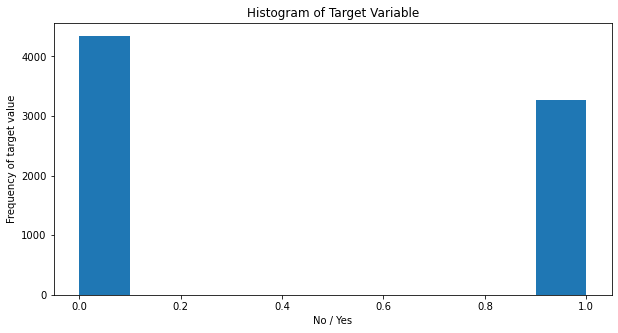

In [8]:
disaster_tweets = disaster_original.copy()

plt.figure(figsize=(10, 5))
plt.hist(disaster_tweets['target'])
plt.title('Histogram of Target Variable')
plt.xlabel('No / Yes')
plt.ylabel('Frequency of target value')
plt.show()

#### Startified Sampling:

The slight imbalance of target values above (in favour of no disaster) indicate that we should conduct Stratified Sampling. Using pre-built SKLearn methods this technique maintains the same distribution of independent variables throughout each of our stratified samples (training and validation).


Here we opted for an initial 80/20 split due to the relatively low number of tweets, however this parameter can have a direct affect on model accruacy and should be considered in the same respect as every other hyperparameter

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(disaster_tweets, disaster_tweets['target']):
    
    strat_training_set = disaster_tweets.loc[train_index]
    strat_testing_set = disaster_tweets.loc[test_index]

With our samples ready we can now visualise the distribution of the dependent variable across each of these samples and compare them with the original dataset.

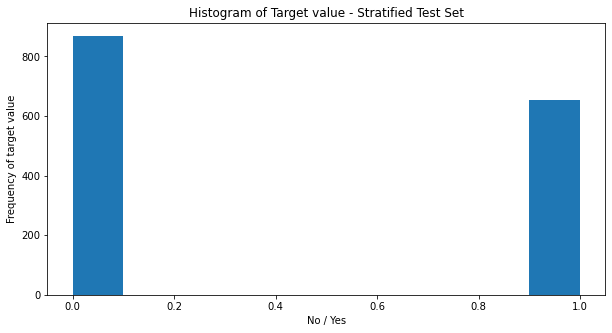

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(strat_testing_set['target'])
plt.xlabel('No / Yes')
plt.ylabel('Frequency of target value')
plt.title('Histogram of Target value - Stratified Test Set')
plt.show()

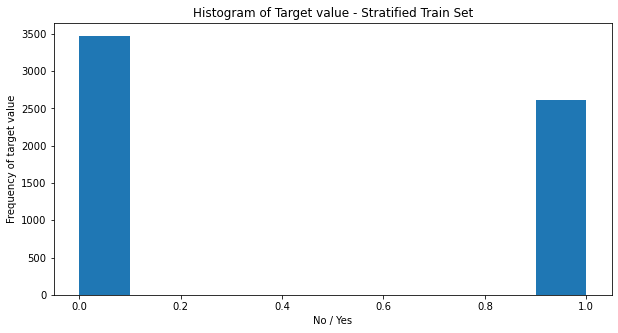

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(strat_training_set['target'])
plt.xlabel('No / Yes')
plt.ylabel('Frequency of target value')
plt.title('Histogram of Target value - Stratified Train Set')
plt.show()

#### Text preprocessing:

To begin to understand any text data it's important to represent the data in an appropriate format. This means taking ech tweet and embedding the text in vector space using the TF-IDF (Term Frequency- Invert Document Frequency) distance metric. TF-IDF creates a sparse matrix of documents * words, with a words TF-IDF value assigned to each field.

In order to embed tweets we first need to clean the text, which involves a number of steps;

- Make all text lowercase.
- Tokensie the text (turn each tweet into a list of string tokens).
- Remove stopwords (removing redundant words like 'and', 'the' or 'a').
- Stemming the text (taking each word down to its root).


In order to ensure easy and efficient reporducability, these formatting techniques are performed by our custom function.



Splitting the Stratified Samples:

Our final task in this part of the data processing simply invovles seperting our independent and dependent variables.

In [18]:
X_train = strat_training_set.drop(columns=['target'])
Y_train = strat_training_set['target']

X_test = strat_testing_set.drop(columns=['target'])
Y_test = strat_testing_set['target']

#### Word Vectorisation:

As an initial method of numerically representing each tweet we opted for TF-IDF, which measure the count of words in a particular document but balances this with the appearence of that word over the whole corpus (every tweet included in the data).

An alternative (and possibly better vector technique) would be to uslise a word2vec model to embed our tweets and assign vector values. This is something we plan to explore in the future, however the ease with which we can implement TF-IDF using built in SKLearn classes and functions make it a good starting point to begin fitting our model.

To achieve this vectorisation we first preprocess all of our tweets (seen and unseen data) and instantiate a TDidfVectorizer object which will perform the necessary calculations to assign TF-IDF values to each of our documents. We then use this trained model to assign features to our stratified samples.

In [20]:
tf_idf_vect = TfidfVectorizer(max_features=300, sublinear_tf=True)
tf_idf_vect.fit(disaster_tweets['text'])

X_train_tfidf = tf_idf_vect.transform(X_train['text'])
X_test_tfidf = tf_idf_vect.transform(X_test['text'])

In [39]:
X_train_tfidf

<6090x300 sparse matrix of type '<class 'numpy.float64'>'
	with 42209 stored elements in Compressed Sparse Row format>

In [34]:
X_test_tfidf

<1523x300 sparse matrix of type '<class 'numpy.float64'>'
	with 10434 stored elements in Compressed Sparse Row format>

This results in a sparse matrix of numerical values to represent each of the tweets. Using this sparse matrix we can visualise our tweets in vector space and assign a hue based on the target variable.

In [26]:
from sklearn.decomposition import TruncatedSVD
tSVD = TruncatedSVD(n_components=3)
data_3d = tSVD.fit_transform(X_train_tfidf)

svd_df = pd.DataFrame()
svd_df['svd_one'] = data_3d[:, 0]
svd_df['svd_two'] = data_3d[:, 1]
svd_df['svd_three'] = data_3d[:, 2]

In [32]:
(svd_df, strat_training_set)

(       svd_one   svd_two  svd_three
 0     0.373265  0.158637  -0.060815
 1     0.378688  0.025709   0.065466
 2     0.173394 -0.168664  -0.169544
 3     0.028284 -0.067702  -0.030288
 4     0.238145  0.003018  -0.015467
 ...        ...       ...        ...
 6085  0.124629 -0.113185  -0.048978
 6086  0.434697  0.200167  -0.030405
 6087  0.069993 -0.095966  -0.071969
 6088  0.261049 -0.091606  -0.085238
 6089  0.086555 -0.198136  -0.107199
 
 [6090 rows x 3 columns],
          id         keyword                       location  \
 6234   8902       snowstorm                     South, USA   
 326     472      armageddon                      Worldwide   
 997    1448  body%20bagging                        Cloud 9   
 7269  10407       whirlwind  Sheff/Bangor/Salamanca/Madrid   
 2189   3137          debris                       Nigeria    
 ...     ...             ...                            ...   
 3386   4848      evacuation                    Yellowknife   
 3280   4706       epice

### Naive Bayes:

Naive Bayes performs well with a small amount of data and uses prior knowledge to calculate a posterior probability, represented by a probability distribution which reflects the likelihood that a specific instance belongs to a particular class.

With our data prepared we can instantiate a Naive Bayes classifier by invoking an SKLearn class, initially maintaining default parameters to establish a baseline performance. We will use this baseline performance as a means of deciding whether to further explore the parameter space of Naive Bayes, or consider a different model for our problem.

In [22]:
nb = naive_bayes.MultinomialNB()
nb.fit(X_train_tfidf, Y_train)

MultinomialNB()

In [23]:
nb_validation_predictions = nb.predict(X_test_tfidf)
nb_training_predictions = nb.predict(X_train_tfidf)

In [24]:
print(f"Naive Bayes Basline Validation Accuracy: {accuracy_score(nb_validation_predictions, Y_test) * 100}")
print(f"Naive Bayes Basline Training Accuracy: {accuracy_score(nb_training_predictions, Y_train) * 100}")

Naive Bayes Basline Validation Accuracy: 75.7715036112935
Naive Bayes Basline Training Accuracy: 76.91297208538587


Results:

Our baseline Naive Bayes model performed relatively well (although there is plenty of room for improvement) achieving 75.77% accuracy on the unseen validation data. What's intersting is that our training accuracy has a very similiar value to our validation accuracy, indicating that the model is indeed a good fit.